# 查看FashionMNIST原始数据格式

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from classificatiom_model import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from classificatiom_model import evaluate_classification_model as evaluate_model



# 加载数据并处理为tensor

In [3]:
from pathlib import Path

DATA_DIR = Path("./archive/")

# 定义数据预处理
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((128, 128)),  # 调整图像大小为128x128
        transforms.ToTensor(),  # 将图像转换为Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化，使用ImageNet的均值和标准差
    ]),
    'validation': transforms.Compose([
        transforms.Resize((128, 128)),  # 调整图像大小为128x128
        transforms.ToTensor(),  # 将图像转换为Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化，使用ImageNet的均值和标准差
    ]),
}

# 使用ImageFolder加载数据
# ImageFolder假设数据集按照如下方式组织：root/class/image.jpg
train_dataset = datasets.ImageFolder(
    root=DATA_DIR / 'training',
    transform=data_transforms['training']
)

test_dataset = datasets.ImageFolder(
    root=DATA_DIR / 'validation',
    transform=data_transforms['validation']
)

# 打印类别信息
class_names = train_dataset.classes
print(f"类别数量: {len(class_names)}")
print(f"类别名称: {class_names}")

# 查看一个样本
img, label = train_dataset[0]
print(f"图像形状: {img.shape}")  # 应该是[3, 128, 128]
print(f"标签: {label} (类别: {class_names[label]})")


类别数量: 10
类别名称: ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
图像形状: torch.Size([3, 128, 128])
标签: 0 (类别: n0)


In [4]:
from pathlib import Path

DATA_DIR = Path("./archive/")

# 自定义数据集类，继承ImageFolder
class MonkeyDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root=root, transform=transform)
        
    # def __getitem__(self, index):
    #     # 调用父类的__getitem__方法获取图像和标签
    #     img, label = super(MonkeyDataset, self).__getitem__(index)
    #     return img, label

# 定义数据预处理
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((128, 128)),  # 调整图像大小为128x128
        transforms.ToTensor(),  # 将图像转换为Tensor
        transforms.Normalize(mean=[0.4363, 0.4328, 0.3291], std=[0.2085, 0.2032, 0.1988])  # 标准化，使用ImageNet的均值和标准差
    ]),
    'validation': transforms.Compose([
        transforms.Resize((128, 128)),  # 调整图像大小为128x128
        transforms.ToTensor(),  # 将图像转换为Tensor
        transforms.Normalize(mean=[0.4363, 0.4328, 0.3291], std=[0.2085, 0.2032, 0.1988])  # 标准化，使用ImageNet的均值和标准差
    ]),
}

# 使用自定义的MonkeyDataset加载数据
train_dataset = MonkeyDataset(
    root=DATA_DIR / 'training',
    transform=data_transforms['training']
)

test_dataset = MonkeyDataset(
    root=DATA_DIR / 'validation',
    transform=data_transforms['validation']
)

# 打印类别信息
class_names = train_dataset.classes
print(f"类别数量: {len(class_names)}")
print(f"类别名称: {class_names}")

# 查看一个样本
img, label = train_dataset[0]
print(f"图像形状: {img.shape}")  # 应该是[3, 128, 128]
print(f"标签: {label} (类别: {class_names[label]})")


类别数量: 10
类别名称: ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
图像形状: torch.Size([3, 128, 128])
标签: 0 (类别: n0)


In [5]:
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2)) #dim=(1, 2)表示在通道维度上求平均
        std += img.std(dim=(1, 2))  #dim=(1, 2)表示在通道维度上求标准差
    mean /= len(ds)
    std /= len(ds)
    return mean, std
cal_mean_std(train_dataset)

(tensor([ 1.5299e-04,  3.6267e-05, -6.5391e-07]),
 tensor([0.9999, 0.9999, 1.0002]))

# 把数据集划分为训练集55000和验证集5000，并给DataLoader

In [6]:


# 创建数据加载器
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# 打印数据集大小信息
print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"批次大小: {batch_size}")
print(f"训练批次数: {len(train_loader)}")


训练集大小: 1097
测试集大小: 272
批次大小: 32
训练批次数: 35


In [7]:
64*860

55040

# 搭建模型

In [8]:
#理解每个接口的方法，单独写例子
import torch.nn as nn
m=nn.BatchNorm1d(100)
x=torch.randn(20,100)
print(m(x).shape)

torch.Size([20, 100])


# 解析padding超参

In [9]:
# 初始化一个5*5的卷积层，保持输入输出图像尺寸不变
# 为了保持尺寸不变，需要设置适当的padding
# 对于kernel_size=5的卷积，需要padding=2才能保持尺寸不变

# 示例：创建一个单通道输入，16通道输出的卷积层
in_channels = 1
out_channels = 16
kernel_size = 5
padding = 2  # padding = (kernel_size - 1) / 2 可以保持尺寸不变

# 创建卷积层
# padding='same' 表示使用动态padding，保持输入输出图像尺寸不变,为same时，步长只能为1
# padding='valid' 表示不使用padding，输出图像尺寸会变小
conv = nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2,stride=2)

# 创建一个示例输入(批次大小为4，单通道，28x28的图像)
x = torch.randn(4, 1, 28, 28)

# 前向传播
output = conv(x)

# 打印输入和输出的形状，验证尺寸是否保持不变
print(f"输入形状: {x.shape}")
print(f"输出形状: {output.shape}")
print(f"参数数量: {sum(p.numel() for p in conv.parameters())}")


输入形状: torch.Size([4, 1, 28, 28])
输出形状: torch.Size([4, 16, 14, 14])
参数数量: 416


In [10]:
128//2//2//2

16

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 第一组卷积层 - 32个卷积核
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # 输入通道数，输出通道数代表的是卷积核的个数
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 第二组卷积层 - 64个卷积核
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        
        # 第三组卷积层 - 128个卷积核
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        
        # 计算全连接层的输入特征数
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 10)
        
        # 初始化权重
        self.init_weights()
        
    def init_weights(self):
        """使用 xavier 均匀分布来初始化卷积层和全连接层的权重"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]
        
        # 第一组卷积层
        x = F.relu(self.conv1(x))
        # print(f"conv1后的形状: {x.shape}")
        x = F.relu(self.conv2(x))
        # print(f"conv2后的形状: {x.shape}")
        x = self.pool(x)
        # print(f"pool1后的形状: {x.shape}")
        
        # 第二组卷积层
        x = F.relu(self.conv3(x))
        # print(f"conv3后的形状: {x.shape}")
        x = F.relu(self.conv4(x))
        # print(f"conv4后的形状: {x.shape}")
        x = self.pool(x)
        # print(f"pool2后的形状: {x.shape}")
        
        # 第三组卷积层
        x = F.relu(self.conv5(x))
        # print(f"conv5后的形状: {x.shape}")
        x = F.relu(self.conv6(x))
        # print(f"conv6后的形状: {x.shape}")
        x = self.pool(x)
        # print(f"pool3后的形状: {x.shape}")
        
        # 展平
        x = x.view(x.size(0), -1)
        # print(f"展平后的形状: {x.shape}")
        
        # 全连接层
        x = F.relu(self.fc1(x))
        # print(f"fc1后的形状: {x.shape}")
        x = self.fc2(x)
        # print(f"fc2后的形状: {x.shape}")
        
        return x


In [12]:
# 实例化模型
model = NeuralNetwork()

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)
    

print(outputs.shape)


批次图像形状: torch.Size([32, 3, 128, 128])
批次标签形状: torch.Size([32])
----------------------------------------------------------------------------------------------------
torch.Size([32, 10])


In [13]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")


需要求梯度的参数总量: 8678442
模型总参数量: 8678442

各层参数量明细:
conv1.weight: 864 参数
conv1.bias: 32 参数
conv2.weight: 9216 参数
conv2.bias: 32 参数
conv3.weight: 18432 参数
conv3.bias: 64 参数
conv4.weight: 36864 参数
conv4.bias: 64 参数
conv5.weight: 73728 参数
conv5.bias: 128 参数
conv6.weight: 147456 参数
conv6.bias: 128 参数
fc1.weight: 8388608 参数
fc1.bias: 256 参数
fc2.weight: 2560 参数
fc2.bias: 10 参数


In [14]:
128*3*3*256

294912

# 各层参数量明细:
conv1.weight: 288 参数 3*3*1*32
conv1.bias: 32 参数
conv2.weight: 9216 参数 3*3*32*32
conv2.bias: 32 参数  
conv3.weight: 18432 参数 3*3*32*64
conv3.bias: 64 参数
conv4.weight: 36864 参数  3*3*64*64
conv4.bias: 64 参数
conv5.weight: 73728 参数
conv5.bias: 128 参数
conv6.weight: 147456 参数
conv6.bias: 128 参数
fc1.weight: 294912 参数 128*3*3*256
fc1.bias: 256 参数
fc2.weight: 2560 参数
fc2.bias: 10 参数

In [15]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 0.0351,  0.0746,  0.1303],
                        [-0.1172,  0.1241, -0.1037],
                        [-0.0206,  0.0391,  0.0618]],
              
                       [[-0.1304, -0.0191, -0.0673],
                        [-0.0993,  0.0699,  0.0429],
                        [ 0.0922, -0.1333,  0.0147]],
              
                       [[ 0.1052,  0.0411, -0.0455],
                        [-0.0100, -0.0093,  0.0203],
                        [ 0.0313, -0.0346,  0.0781]]],
              
              
                      [[[ 0.1358,  0.0592, -0.1285],
                        [ 0.1035,  0.1199,  0.0384],
                        [ 0.1374,  0.0045,  0.0797]],
              
                       [[ 0.0474, -0.0621,  0.0359],
                        [-0.1171, -0.0058, -0.0800],
                        [-0.1248, -0.0620, -0.0109]],
              
                       [[-0.0725, -0.0384, -0.1099],
                        [ 

# 设置交叉熵损失函数，SGD优化器

In [16]:
model = NeuralNetwork()
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码

print("损失函数:", loss_fn)



损失函数: CrossEntropyLoss()


In [17]:
model = NeuralNetwork()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)


model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=None)



使用设备: cuda:0


Training Progress:   0%|          | 0/1750 [00:00<?, ?it/s]

In [19]:
history['train'][-100:-1]

[{'loss': 0.00016087341646198183, 'acc': 100.0, 'step': 1650},
 {'loss': 0.00012376262748148292, 'acc': 100.0, 'step': 1651},
 {'loss': 0.00027858492103405297, 'acc': 100.0, 'step': 1652},
 {'loss': 7.733277743682265e-05, 'acc': 100.0, 'step': 1653},
 {'loss': 0.00014629312499891967, 'acc': 100.0, 'step': 1654},
 {'loss': 5.877193689229898e-05, 'acc': 100.0, 'step': 1655},
 {'loss': 0.00010482493962626904, 'acc': 100.0, 'step': 1656},
 {'loss': 9.87551175057888e-05, 'acc': 100.0, 'step': 1657},
 {'loss': 0.00013876632147002965, 'acc': 100.0, 'step': 1658},
 {'loss': 0.00016856692673172802, 'acc': 100.0, 'step': 1659},
 {'loss': 0.0002506825258024037, 'acc': 100.0, 'step': 1660},
 {'loss': 0.00015049093053676188, 'acc': 100.0, 'step': 1661},
 {'loss': 0.00032546473084948957, 'acc': 100.0, 'step': 1662},
 {'loss': 0.00016565967234782875, 'acc': 100.0, 'step': 1663},
 {'loss': 0.00013308787310961634, 'acc': 100.0, 'step': 1664},
 {'loss': 0.000119059368444141, 'acc': 100.0, 'step': 1665},

In [20]:
history['val'][-1000:-1]

[{'loss': 2.3028473293080047, 'acc': 11.029411764705882, 'step': 0},
 {'loss': 1.7820837217218735, 'acc': 56.61764705882353, 'step': 500},
 {'loss': 2.629711691071005, 'acc': 61.029411764705884, 'step': 1000}]

# 绘制损失曲线和准确率曲线

In [21]:
# 导入绘图库
import matplotlib.pyplot as plt
from matplotlib import font_manager
def plot_learning_curves1(history):
    # 设置中文字体支持
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
    plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

    # 创建一个图形，包含两个子图（损失和准确率）
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 绘制损失曲线
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], 'b-', label='训练损失')
    ax1.plot(epochs, history['val_loss'], 'r-', label='验证损失')
    ax1.set_title('训练与验证损失')
    ax1.set_xlabel('轮次')
    ax1.set_ylabel('损失')
    ax1.legend()
    ax1.grid(True)

    # 绘制准确率曲线
    ax2.plot(epochs, history['train_acc'], 'b-', label='训练准确率')
    ax2.plot(epochs, history['val_acc'], 'r-', label='验证准确率')
    ax2.set_title('训练与验证准确率')
    ax2.set_xlabel('轮次')
    ax2.set_ylabel('准确率 (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


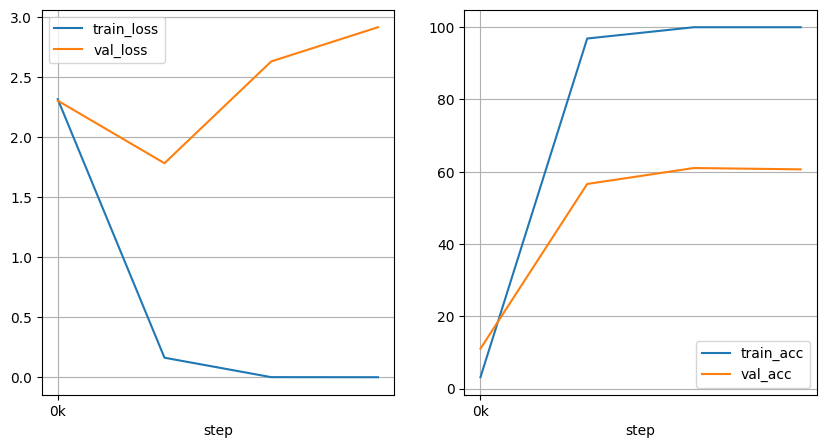

In [22]:
plot_learning_curves(history, sample_step=500)  #横坐标是 steps

In [23]:
# 在测试集上评估模型
test_accuracy = evaluate_model(model, test_loader, device, loss_fn)
test_accuracy


(60.661764705882355, 3.000528833445381)